In [23]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: marcodia
"""
import numpy as np
import random
import xarray as xr
import pandas as pd
import datetime as dt
import time
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy import signal

from sklearn import preprocessing
import tensorflow as tf

import import_ipynb
import sys
import os 

import settings

import network_arch as network
import metrics
import plot
import settings

import cftime
import matplotlib.pyplot as plt
import nc_time_axis

import statsmodels.api as sm
# Temporal correlation between the two time series
import genutil

from cartopy import config
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from shapely.geometry.polygon import LinearRing
import matplotlib.colors as mcolors

## Correlate the Accuracy of NNs with the PDO Index

In [3]:
example = xr.open_dataset('/Users/marcodia/Research/pcmdi_metrics_install08192022/pcmdi_metrics/doc/jupyter/Demo/demo_output'+'/CESM2-LE/NINO34_SST_monthly_CESM-LE_CESM-LE-ens'+str(0)+'_historical_ens'+str(0)+'_mo_atm_1851-1949.nc')
example_time = np.array(example.time)


In [4]:
running_window_yr = 10 #running mean
days_per_annualszn = 30+31+31+28 #(Nov-Feb)

running_window = running_window_yr * days_per_annualszn
array_size = 100 - running_window_yr
num_experiments = 10
num_seeds = 10 
climate_mode = 'PDO'


timeplot = np.arange(1850,1950)
timeplot = timeplot[running_window_yr:(len(timeplot))]

if climate_mode == 'NINO34':
    example = xr.open_dataset('/Users/marcodia/Research/pcmdi_metrics_install08192022/pcmdi_metrics/doc/jupyter/Demo/demo_output'+'/CESM2-LE/NINO34_SST_monthly_CESM-LE_CESM-LE-ens'+str(0)+'_historical_ens'+str(0)+'_mo_atm_1851-1949.nc')
    example_time = np.array(example.time)
    mode_index = xr.DataArray(np.zeros([num_experiments,1200]),dims = ['experiment','time'],coords = [('experiment',np.arange(0,num_experiments)),('time',example_time)])
else:
    example = xr.open_dataset('/Users/marcodia/Research/pcmdi_metrics_install08192022/pcmdi_metrics/doc/jupyter/Demo/demo_output'+'/CESM2-LE/PDO_SST_EOF1_monthly_CESM-LE_CESM-LE-ens'+str(9)+'_historical_ens'+str(9)+'_mo_atm_1851-1949.nc')['pc']
    example_time = np.array(example.time)
    mode_index = xr.DataArray(np.zeros([num_experiments,1188]),dims = ['experiment','time'],coords = [('experiment',np.arange(0,num_experiments)),('time',example_time)])

accuracy_trained_runavg = xr.DataArray(np.zeros([num_experiments,num_seeds,array_size]),dims = ['experiment','seed','year_avg'],coords = [('experiment',np.arange(0,num_experiments)),('seed',np.arange(0,num_seeds)),('year_avg',timeplot)])
overall_accuracy_all_trained = xr.DataArray(np.zeros([num_experiments,num_seeds]),dims = ['experiment','seed'],coords = [('experiment',np.arange(0,num_experiments)),('seed',np.arange(0,num_seeds))])
confident_preds_runavg = xr.DataArray(np.zeros([num_experiments,num_seeds,array_size]),dims = ['experiment','seed','year_avg'],coords = [('experiment',np.arange(0,num_experiments)),('seed',np.arange(0,num_seeds)),('year_avg',timeplot)])
least_confident_preds_runavg = xr.DataArray(np.zeros([num_experiments,num_seeds,array_size]),dims = ['experiment','seed','year_avg'],coords = [('experiment',np.arange(0,num_experiments)),('seed',np.arange(0,num_seeds)),('year_avg',timeplot)])

ind = 0 

exp_num = 1

percentile = 80
per = 100-percentile 

In [6]:
for sub_exp in np.arange(exp_num*100,exp_num*100+10):
    EXPERIMENT = 'exp_'+str(exp_num)+'/exp_'+str(sub_exp)
    ddir_trained = '/Users/marcodia/Research/Data/processed_fields/Week_45/'+EXPERIMENT+'/'
    params = settings.get_settings(EXPERIMENT)

    print(EXPERIMENT)
    
    PREDICTOR_VAR  = params['PREDICTOR_VAR']           
    PREDICTAND_VAR = params['PREDICTAND_VAR']              
    REGION_TOR     = params['REGION_TOR']          
    REGION_TAND    = params['REGION_TAND']            
    training_ens   = params['training_ens']            
    validation_ens = params['validation_ens']           
    testing_ens    = params['testing_ens']           
    train_list     = params['train_list']           
    lead           = params['lead']            
    days_average   = params['days_average']            
    GLOBAL_SEED    = params['GLOBAL_SEED']            
    HIDDENS        = params['HIDDENS']          
    DROPOUT        = params['DROPOUT']            
    RIDGE1         = params['RIDGE1']                    
    LR_INIT        = params['LR_INIT']
    BATCH_SIZE     = params['BATCH_SIZE']           
    RANDOM_SEED    = params['RANDOM_SEED']            
    act_fun        = params['act_fun']            
    N_EPOCHS       = params['N_EPOCHS']           
    PATIENCE       = params['PATIENCE']   
    
    #>>>>>SET UP <<<<<<<<<<<<<<<
    np.random.seed(GLOBAL_SEED)
    random.seed(GLOBAL_SEED)
    tf.compat.v1.random.set_random_seed(GLOBAL_SEED)

    ind2= 0 
    for SEED in RANDOM_SEED:
        if ind2 < num_experiments:
            accuracy_trained_runavg[ind,ind2,:] = xr.open_dataarray(ddir_trained+'accuracy_testdata_'+str(running_window_yr)+'yr_runavg_exp'+EXPERIMENT[-3:]+'_seed'+str(SEED)+'.nc')
            overall_accuracy_all_trained[ind,:] = xr.open_dataarray(ddir_trained+'overall_accuracy_testdata'+'_exp'+EXPERIMENT[-3:]+'_allseeds'+'.nc')
            confident_preds_runavg[ind,:,:] = xr.open_dataarray(ddir_trained+str(per)+'confidence_vs_accuracy_'+str(running_window_yr)+'yr_runavg_'+EXPERIMENT[-3:]+'_allseeds'+'_UPDATED.nc')
            least_confident_preds_runavg[ind,:,:] = xr.open_dataarray(ddir_trained+str(per)+'confidence_vs_accuracy_'+str(running_window_yr)+'yr_runavg_'+EXPERIMENT[-3:]+'_allseeds'+'_UPDATED.nc')
            ind2 = ind2+1
    
    if climate_mode == 'NINO34':
        mode_index[ind,:] = xr.open_dataarray('/Users/marcodia/Research/pcmdi_metrics_install08192022/pcmdi_metrics/doc/jupyter/Demo/demo_output'+'/CESM2-LE/'+climate_mode+'_SST_monthly_CESM-LE_CESM-LE-ens'+str(testing_ens)+'_historical_ens'+str(testing_ens)+'_mo_atm_1851-1949.nc')
    else:
        mode_index[ind,:] = xr.open_dataset('/Users/marcodia/Research/pcmdi_metrics_install08192022/pcmdi_metrics/doc/jupyter/Demo/demo_output'+'/CESM2-LE/'+climate_mode+'_SST_EOF1_monthly_CESM-LE_CESM-LE-ens'+str(testing_ens)+'_historical_ens'+str(testing_ens)+'_mo_atm_1851-1949.nc')['pc']

    
    ind = ind+1 

exp_1/exp_100
exp_1/exp_101
exp_1/exp_102
exp_1/exp_103
exp_1/exp_104
exp_1/exp_105
exp_1/exp_106
exp_1/exp_107
exp_1/exp_108
exp_1/exp_109


In [13]:
confident_preds_runavg['experiment']= confident_preds_runavg.experiment-1 
confident_preds_runavg_reorder = xr.DataArray(np.zeros([num_experiments,num_seeds,array_size]),dims = ['experiment','seed','year_avg'],coords = [('experiment',np.arange(0,num_experiments)),('seed',np.arange(0,num_seeds)),('year_avg',timeplot)])
confident_preds_runavg_reorder[0:9,:,:] = confident_preds_runavg[1:10,:,:]
confident_preds_runavg_reorder[9,:,:] = confident_preds_runavg[0,:,:]
confident_preds_runavg = confident_preds_runavg_reorder

In [14]:
mean_conf_preds = np.mean(confident_preds_runavg, axis=1)
mean_least_conf_preds = np.mean(least_confident_preds_runavg, axis=1)


In [21]:
mode_index['experiment']= mode_index.experiment-1 
mode_index_reorder = xr.DataArray(np.zeros([num_experiments,1188]),dims = ['experiment','time'],coords = [('experiment',np.arange(0,num_experiments)),('time',np.array(mode_index.time))])
mode_index_reorder[0:9,:] = mode_index[1:10,:]
mode_index_reorder[9,:] = mode_index[0,:]
mode_index = mode_index_reorder

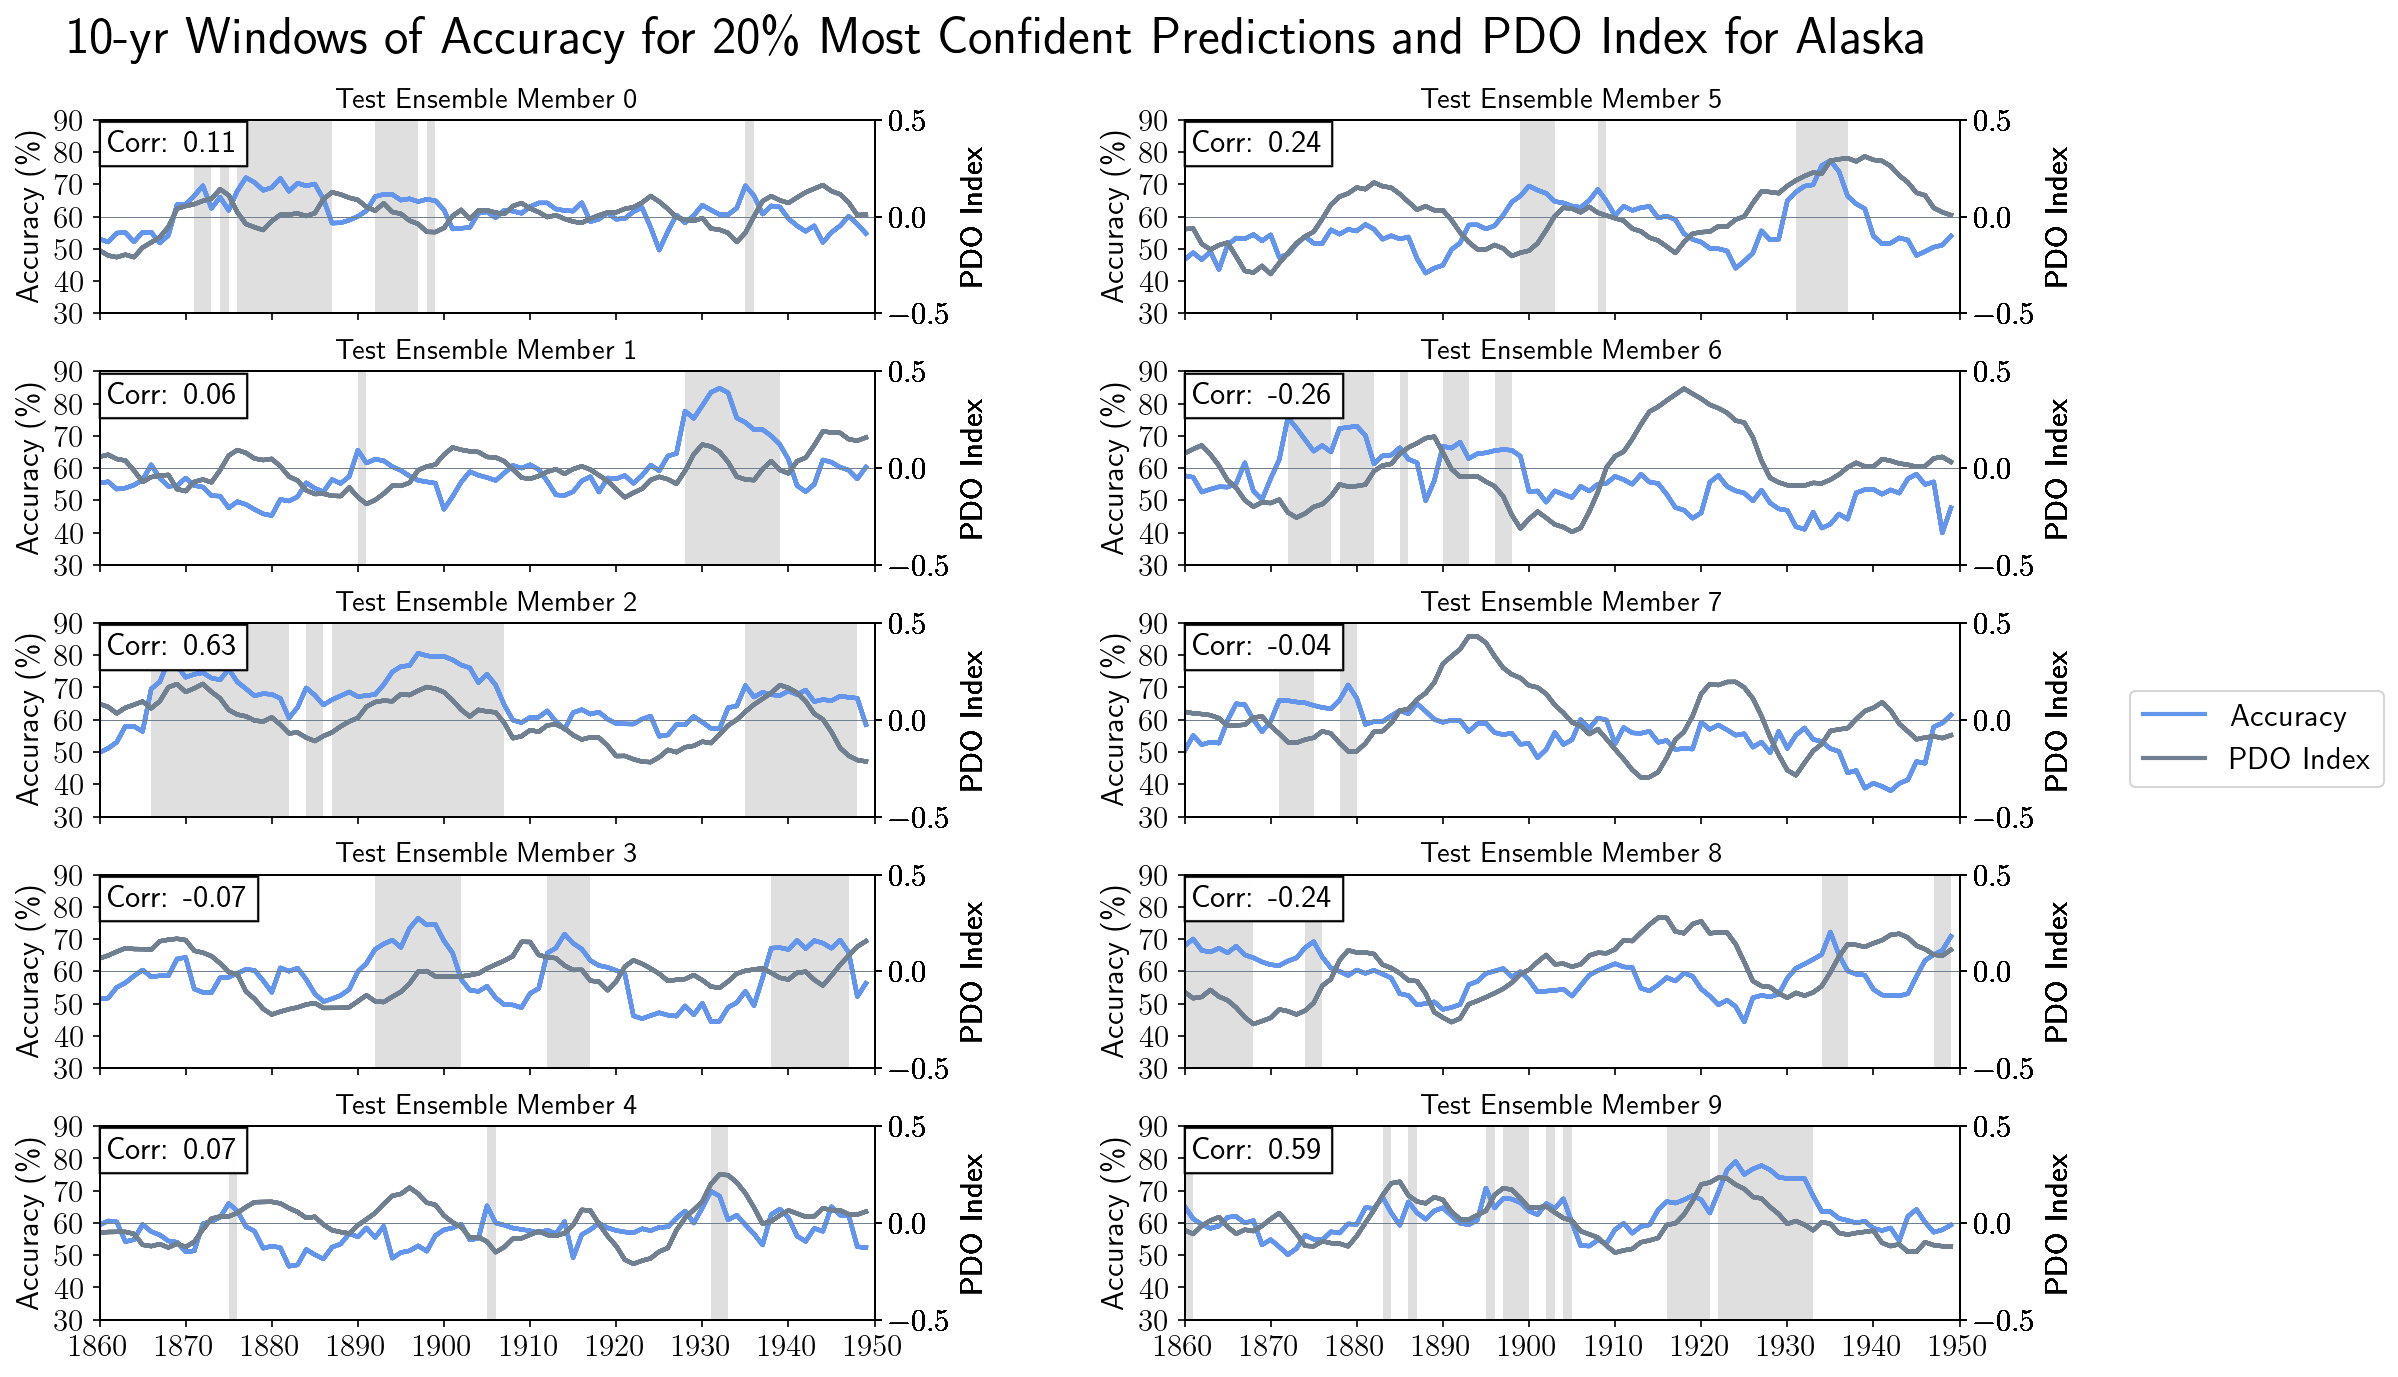

In [22]:
#Plot all the Seeds from all Experiments 
fig, ax = plt.subplots(5,2, sharex= True, figsize=(16,10))

for exp in np.arange(0,10):
    
    mode_annualmean = mode_index[exp,:].groupby('time.year').mean()
    mode_runavg = mode_annualmean.rolling(year=running_window_yr, center=True).mean().dropna(dim='year')
    mode_runavg['year'] = mode_runavg.year+4
    # confident_preds_runavg['experiment']= confident_preds_runavg.experiment-1 
    # confident_preds_runavg_reorder = xr.DataArray(np.zeros([num_experiments,num_seeds,array_size]),dims = ['experiment','seed','year_avg'],coords = [('experiment',np.arange(0,num_experiments)),('seed',np.arange(0,num_seeds)),('year_avg',timeplot)])
    # confident_preds_runavg_reorder[0:9,:,:] = confident_preds_runavg[1:10,:,:]
    # confident_preds_runavg_reorder[9,:,:] = confident_preds_runavg[0,:,:]
    # confident_preds_runavg = confident_preds_runavg_reorder
    # if climate_mode == 'NINO34':
    #     mode_runavg = mode_runavg[1:]
    cross_corr = sm.tsa.stattools.ccf(mean_conf_preds[exp,:],mode_runavg, adjusted = True)

    for ax_row in ax:
        for axT in ax_row:   
            if exp < 5:                
                ax[exp, 0].plot(mean_conf_preds.year_avg, mean_conf_preds[exp,:], color='cornflowerblue', alpha= 0.9,linewidth=2)
                ax2=ax[exp,0].twinx()
                ax2.plot(mode_runavg.year,mode_runavg, color='slategrey', linewidth=2, alpha = 0.9)    

                ax2.set(ylim=(-0.5,0.5))
                #ax2.set(ylim=(-1,1))
                ax2.set(ylabel=climate_mode+' Index')
                ax2.axhline(y=0.0, color='slategrey', linestyle='-', linewidth=0.25)
                #ax2.axhline(y=0.15, color='red', linestyle='-', linewidth=0.25)
                #ax2.axhline(y=-0.15, color='red', linestyle='-', linewidth=0.25)
                ax[exp, 0].set(xlim=(timeplot[0],timeplot[-1]+1))
                ax[exp, 0].set(xticks=(np.arange(timeplot[0],timeplot[-1]+5,step=10)))
                ax[exp, 0].set(ylim=(30,90))
                ax[exp, 0].set(yticks=(np.arange(30,95, step=10)))
                #ax[exp, 0].set_title('Experiment '+str(exp_num)+'0'+str(exp),fontsize =14)
                # if exp == 0: 
                #     ax[exp, 0].set_title('Test Ensemble Member '+str(9),fontsize =14)
                # else:
                ax[exp, 0].set_title('Test Ensemble Member '+str(exp),fontsize =14)
                ax[exp, 0].set(ylabel='Accuracy (\%)')
                #ax[exp, 0].axhline(y=60, color='black', linestyle='-', linewidth=0.25)
                ax[exp, 0].text(1861,80,'Corr: '+str(np.round(cross_corr[0],2)), bbox = dict(facecolor = 'white', alpha=0.8))

                high_acc_index = np.where(mean_conf_preds[exp,:]>65)
                #print(high_acc_index)
                shade_box = mean_conf_preds.year_avg[high_acc_index]
                #print(shade_box)
                for s in np.arange(0,len(shade_box)-1):
                    ax[exp,0].axvspan(shade_box[s],shade_box[s]+1, alpha=0.1, facecolor='lightgrey')
                #print(exp)
            if exp >= 5:  


                ax[exp-5, 1].plot(mean_conf_preds.year_avg, mean_conf_preds[exp,:], color='cornflowerblue', alpha= 0.9,linewidth=2)
                ax2=ax[exp-5,-1].twinx()
                ax2.axhline(y=1000.0, color='cornflowerblue', linestyle='-', linewidth=2)
                ax2.axhline(y=1000.0, color='slategrey', linestyle='-', linewidth=2)

                ax2.axhline(y=0.0, color='slategrey', linestyle='-', linewidth=0.25)
                ax2.plot(mode_runavg.year,mode_runavg, color='slategrey', linewidth=2, alpha=0.9)  

                ax2.set(ylim=(-0.5,0.5))
                #ax2.set(ylim=(-1,1))
                ax2.set(ylabel=climate_mode+' Index')
          
                ax[exp-5, 1].set(xlim=(timeplot[0],timeplot[-1]+1))
                ax[exp-5, 1].set(xticks=(np.arange(timeplot[0],timeplot[-1]+5,step=10)))
                ax[exp-5, 1].set(ylim=(30,90))
                ax[exp-5, 1].set(yticks=(np.arange(30,95, step=10)))
                ax[exp-5, 1].set_title('Test Ensemble Member '+str(exp),fontsize =14)
                ax[exp-5, 1].set(ylabel='Accuracy (\%)')
                ax[exp-5, 1].text(1861,80,'Corr: '+str(np.round(cross_corr[0],2)), bbox = dict(facecolor = 'white', alpha=0.8))
                high_acc_index = np.where(mean_conf_preds[exp,:]>65)
                shade_box = mean_conf_preds.year_avg[high_acc_index]
                for s in np.arange(0,len(shade_box)-1):
                    ax[exp-5,1].axvspan(shade_box[s],shade_box[s]+1, alpha=0.1, facecolor='lightgrey')
labels = ['Accuracy',climate_mode+' Index']
colors = ['cornflowerblue','slategrey']
fig.subplots_adjust(top=0.91, hspace=0.3, wspace=0.4)
plt.suptitle((str(running_window_yr)+'-yr Windows of Accuracy for '+str(per)+'\% Most Confident Predictions and '+climate_mode+' Index for Alaska'), fontsize='25')
plt.legend(labels, loc='center left',ncol=1, bbox_to_anchor=(1.2, 3.0))
